##`author: Bitingo Josaphat JB`
`Email :` bitingojosaphat@gmail.com

In [36]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

This command shows list of physical devices available for tensorflow. You can see GPU listed here. If you have NVIDIA GPU you need to install CUDA toolkit and cuDNN as per instruction on this webpage. Without proper installation you will not see GPU in list of devices

In [37]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [38]:
tf.__version__

'2.7.0'

In [39]:
tf.test.is_built_with_cuda()

True

####Load the dataset
Our dataset contains 60000 small training images that belongs to one of the below 10 classes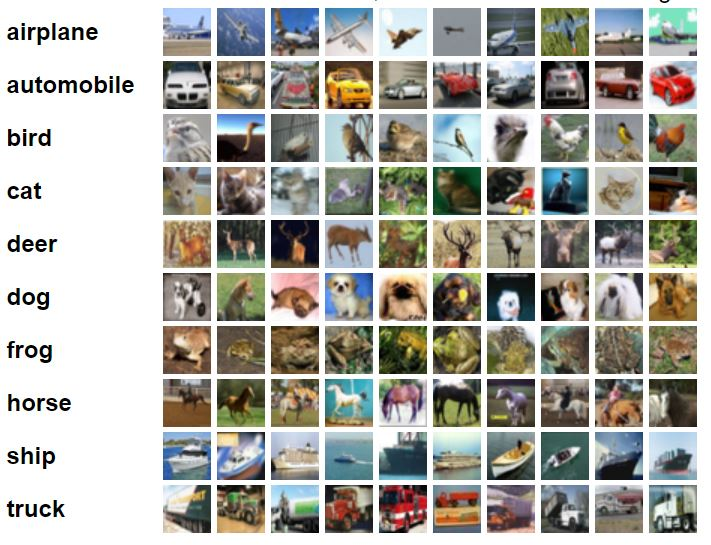

In [40]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.cifar10.load_data()

In [41]:
X_train.shape

(50000, 32, 32, 3)

In [42]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [43]:
y_train[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [44]:
y_test.shape

(10000, 1)

###Data Prepocessing

In [45]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [46]:
y_train_categorical = keras.utils.to_categorical(y_train,num_classes = 10, dtype= 'float32')

y_test_categorical = keras.utils.to_categorical(y_test,num_classes = 10, dtype = 'float32')

In [47]:
def get_model():
  model = tf.keras.Sequential([
      keras.layers.Flatten(input_shape =(32,32,3)),
      keras.layers.Dense(3000, activation = 'relu'),
      keras.layers.Dense(1000, activation = 'relu'),
      keras.layers.Dense(10, activation = 'sigmoid')
  ])
  model.compile(
    optimizer = 'SGD',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
  )

  return model

In [49]:
train_tf_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_categorical))
test_tf_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_categorical))

In [50]:
type(train_tf_dataset)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [52]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [53]:
strategy.num_replicas_in_sync

1

In [55]:
BATCH_SIZE_PER_REPLICA = 1000
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

train_dataset = train_tf_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_tf_dataset.batch(BATCH_SIZE)

In [57]:
%%timeit -n1 -r1
with strategy.scope():
  gpu_model = get_model()
  gpu_model.fit(train_dataset, epochs = 5)

Epoch 1/5
50/50 [==============================] - 43s 839ms/step - loss: 2.1134 - accuracy: 0.2515
Epoch 2/5
50/50 [==============================] - 42s 839ms/step - loss: 1.9570 - accuracy: 0.3239
Epoch 3/5
50/50 [==============================] - 42s 842ms/step - loss: 1.8910 - accuracy: 0.3501
Epoch 4/5
50/50 [==============================] - 42s 844ms/step - loss: 1.8501 - accuracy: 0.3626
Epoch 5/5
50/50 [==============================] - 42s 842ms/step - loss: 1.8208 - accuracy: 0.3726
1 loop, best of 1: 6min 52s per loop


###***Measure training time on a CPU***

In [59]:
%%timeit -n1 -r1
with tf.device('/CPU:0'):
  cpu_model = get_model()
  cpu_model.fit(train_dataset, epochs = 5)

Epoch 1/5
50/50 [==============================] - 43s 854ms/step - loss: 2.1248 - accuracy: 0.2524
Epoch 2/5
50/50 [==============================] - 44s 878ms/step - loss: 1.9660 - accuracy: 0.3223
Epoch 3/5
50/50 [==============================] - 51s 1s/step - loss: 1.8993 - accuracy: 0.3458
Epoch 4/5
50/50 [==============================] - 43s 853ms/step - loss: 1.8568 - accuracy: 0.3606
Epoch 5/5
50/50 [==============================] - 44s 875ms/step - loss: 1.8262 - accuracy: 0.3696
1 loop, best of 1: 5min 34s per loop
